# Gesture Recognition
In this group project, you are going to build a 3D Conv model that will be able to predict the 5 gestures correctly. The gestures are:

1. Thumbs up:  Increase the volume
2. Thumbs down: Decrease the volume
3. Left swipe: 'Jump' backwards 10 seconds
4. Right swipe: 'Jump' forward 10 seconds  
5. Stop: Pause the movie



In [2]:
# Importing libraries
import numpy as np
import os
from imageio import imread
from skimage.transform import resize
import datetime
import os
import matplotlib.pyplot as plt
import imageio
from keras.callbacks import ReduceLROnPlateau

We set the random seed so that the results don't vary drastically.

In [3]:
np.random.seed(30)
import random as rn
rn.seed(30)
from tensorflow import keras
import tensorflow as tf
tf.random.set_seed(30)

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

**data path: /home/datasets/Project_data**

In [4]:
# getting train and val_doc location and randomizing to get all classes data
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. You have to experiment with `img_idx`, `y`,`z` and normalization such that you get high accuracy.

In [5]:
def generator(source_path, folder_list, batch_size, num_images,image_height,image_width):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    img_idx = np.round(np.linspace(0,29,num_images)).astype(int) #create a list of image numbers you want to use for a particular video
    
    
    while True:
        t = np.random.permutation(folder_list)
        
        num_batches = len(t)//batch_size
            
        for batch in range(num_batches): # we iterate over the number of batches
            batch_data = np.zeros((batch_size, num_images,image_height,image_width,3)) # x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB
            batch_labels = np.zeros((batch_size,5)) # batch_labels is the one hot representation of the output
            
            for folder in range(batch_size): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate over the frames/images of a folder to read them in
                    image = imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                    
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    image = resize(image, (image_height, image_width), anti_aliasing=True)
                    
                    #normalise and feed in the image. Normalization method: Percentile method
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/ (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/ (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/ (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

        
        # writing the code for the remaining data points which are left after full batches
        if (len(t)%batch_size):
            remaining_videos = len(t)%batch_size
            batch_data   = np.zeros((remaining_videos,num_images,image_height,image_width,3)) # 3 is the number of channels RGB
            batch_labels = np.zeros((remaining_videos,5)) # batch_labels is the one hot representation of the output           

            for folder in range(remaining_videos): # iterate over the batch_size
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0]) # read all the images in the folder
                
                for idx,item in enumerate(img_idx): #  Iterate iver the frames/images of a folder to read them in
                    image = imageio.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item]).astype(np.float32)
                
                    #crop the images and resize them. Note that the images are of 2 different shape 
                    #and the conv3D will throw error if the inputs in a batch have different shapes
                    
                    # cropping rectangle images to square images
                    if image.shape[1] > image.shape[0]:
                        diff_px = image.shape[1] - image.shape[0]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[0]
                        image = image[:, crop_start:crop_end]
                    elif image.shape[0] > image.shape[1]:
                        diff_px = image.shape[0] - image.shape[1]
                        crop_start = diff_px//2
                        crop_end = crop_start + image.shape[1]
                        image = image[:, crop_start:crop_end]
                    
                    # resizing image
                    image = resize(image, (image_height, image_width), anti_aliasing=True)   
                                      
                    #normalise and feed in the image
                    batch_data[folder,idx,:,:,0] = (image[:,:,0] - np.percentile(image[:,:,0],5))/ (np.percentile(image[:,:,0],95) - np.percentile(image[:,:,0],5)) 
                    batch_data[folder,idx,:,:,1] = (image[:,:,1] - np.percentile(image[:,:,1],5))/ (np.percentile(image[:,:,1],95) - np.percentile(image[:,:,1],5))
                    batch_data[folder,idx,:,:,2] = (image[:,:,2] - np.percentile(image[:,:,2],5))/ (np.percentile(image[:,:,2],95) - np.percentile(image[:,:,2],5))
                    
                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1
                
            yield batch_data, batch_labels #you yield the batch_data and the batch_labels, remember what does yield do

Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [6]:
# experimentation hyper parameters
batch_size = 32 #experiment with the batch size
num_images = 20 # number of frames/images in a video for training.
image_height = 120 #image height which will be used during training
image_width = 120 #image width which will be used during training
num_epochs = 40 # choose the number of epochs

In [7]:
# Getting number of training and validation sequences along with epoch length
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 40


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

In [52]:
# importing libraries
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, Dropout, Flatten, BatchNormalization, Activation, Conv3D, MaxPooling3D
from tensorflow.keras.layers import GlobalAveragePooling3D,TimeDistributed,Conv2D,GRU,MaxPooling2D,GlobalAveragePooling2D,ConvLSTM2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers

Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

### Experiment 1 and 2
Experiment 1: Running a sequential Conv 3D model with 2 Conv3D layers followed by a dense layer to get output. No of epochs=10
Experiment 2: In experiment 2, no of epochs 20

In [53]:
# Experiment 1 and 2
# Running a sequential Conv 3D model with 2 Conv3D layers followed by a dense layer to get output
# experiment number: no of epochs:10 and in experiment 2: no of epochs 20

# model = Sequential()
# model.add(Conv3D(32, kernel_size=3, activation='relu', input_shape=(num_images, image_height, image_width, 3)))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Conv3D(64, kernel_size=3, activation='relu'))
# model.add(MaxPooling3D(pool_size=2))

# model.add(Flatten())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment 3
Trying to add four Conv3D layers with 128 kernels followed by max pooling after each layer. Adding a drop-out in last layer

In [54]:
# Experiment 3: Trying to add four Conv3D layers followed by max pooling after each layer. Also increasing the number of filters and adding a drop-out
# in last layer

# model = Sequential()

# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_images, image_height, image_width, 3),activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))

# model.add(Conv3D(64, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
    
# model.add(Conv3D(128, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2))) 
    
# model.add(Flatten())
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(5,activation='softmax'))

### Experiment 4
Adding dropout after each layer and reducing batch size to 32

In [55]:
# Experiment 4. Adding dropout after each layer and reducing batch size to 32

# model = Sequential()

# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_images, image_height, image_width, 3),activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv3D(64, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.3))
    
# model.add(Conv3D(128, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2))) 
# model.add(Dropout(0.3))
    
# model.add(Flatten())
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(5,activation='softmax'))

### Experiment 5
Adding dropout after each layer and reducing batch size to 32. Adding batch normalization after each layer as well

In [56]:
# Experiment 5. Adding dropout after each layer and reducing batch size to 32
# Adding batch normalization after each layer as well

# model = Sequential()

# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_images, image_height, image_width, 3),activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))

# model.add(Conv3D(64, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
    
# model.add(Conv3D(128, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2))) 
# model.add(BatchNormalization())
# model.add(Dropout(0.3))
    
# model.add(Flatten())
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(5,activation='softmax'))

### Experiment 6 and 7

#### Global Average Pooling:
Global Average Pooling is a pooling operation designed to replace fully connected layers in classical CNNs. The idea is to generate one feature map for each corresponding category of the classification task in the last mlpconv layer. Instead of adding fully connected layers on top of the feature maps, we take the average of each feature map, and the resulting vector is fed directly into the softmax layer. 

Will try using Global Average Pooling instead of flatten layer and observe the behavior.

Experiment 7 with number of epochs = 30

In [57]:
# Experiment 6 and 7. Adding dropout after each layer and reducing batch size to 32
# Using global average pooling instead of flatten layer

# model = Sequential()

# model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_images, image_height, image_width, 3),activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.3))

# model.add(Conv3D(64, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2)))
# model.add(Dropout(0.3))
    
# model.add(Conv3D(128, (3, 3, 3), padding='same',activation='relu'))
# model.add(MaxPooling3D(pool_size=(2, 2, 2))) 
# model.add(Dropout(0.3))
    
# model.add(GlobalAveragePooling3D())
# model.add(Dense(256,activation='relu'))
# model.add(Dropout(0.25))

# model.add(Dense(5,activation='softmax'))

### Experiment 8

Using Conv2D + GRU


In [58]:
# Experiment 8 using TimeDistributed Conv2D + GRU

# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3,3),activation='relu'),input_shape=(num_images, image_height, image_width, 3)))
# model.add(TimeDistributed(MaxPooling2D((2,2))))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv2D(64, (3,3), padding='same',activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2,2))))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(TimeDistributed(GlobalAveragePooling2D()))
# model.add(TimeDistributed(Dense(64, activation='relu')))
# model.add(BatchNormalization())
# model.add(Dropout(0.2))

# model.add(GRU(128))
# model.add(BatchNormalization())

# model.add(Dense(5, activation='softmax'))

### Experiment 9 and 10
Using Conv2D + Dense Layer + GlobalAveragePooling3D

In [59]:
# Experiment 9 and 10 using TimeDistributed Conv2D + Dense + GlobalAveragePooling3D without batchNormalization
# model = Sequential()

# model.add(TimeDistributed(Conv2D(32, (3,3),activation='relu'),input_shape=(num_images, image_height, image_width, 3)))
# model.add(TimeDistributed(MaxPooling2D((2,2))))
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv2D(64, (3,3), padding='same',activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2,2))))
# model.add(Dropout(0.2))

# model.add(TimeDistributed(Conv2D(128, (3,3), padding='same',activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2,2))))
# model.add(Dropout(0.2))

# model.add(GlobalAveragePooling3D())
# model.add(Dense(256, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment 11
Conv2D + Conv2DLSTM + GlobalAveragePooling2D

In [60]:
# Experiment 11 using Timedistributed Conv2D and ConvLSTM2D and GlobalAveragePooling2D
# model = Sequential()
# model.add(TimeDistributed(Conv2D(8, (3,3), activation='relu'), input_shape=(num_images, image_height, image_width, 3)))
# #model.add(BatchNormalization())
# model.add(TimeDistributed(Conv2D(16, (3,3), activation='relu')))
# #model.add(BatchNormalization())
# model.add(ConvLSTM2D(8, kernel_size = 3, return_sequences=False))
# #model.add(BatchNormalization())
# model.add(TimeDistributed(Dense(64, activation='relu')))
# #model.add(BatchNormalization())
# model.add(GlobalAveragePooling2D())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Experiment 12
Conv2D + Conv2DLSTM + Flatten layer

In [61]:
# Experiment 12 using Timedistributed Conv2D and ConvLSTM2D and GlobalAveragePooling2D
# model = Sequential()
# model.add(TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(num_images, image_height, image_width, 3)))
# model.add(TimeDistributed(MaxPooling2D((2,2))))

# model.add(TimeDistributed(Conv2D(64, (3,3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2,2))))

# model.add(TimeDistributed(Conv2D(128, (3,3), activation='relu')))
# model.add(TimeDistributed(MaxPooling2D((2,2))))

# model.add(ConvLSTM2D(128, kernel_size = 3, return_sequences=False))

# model.add(TimeDistributed(Dense(64, activation='relu')))

# model.add(Flatten())
# model.add(Dense(64, activation='relu'))
# model.add(Dense(5, activation='softmax'))

### Final Model
using experiment 7 as Final model as it gave best results and training it with batch size = 32, epochs = 40 and num of training images in a sequence = 20. Number of parameters are 313,605

In [ ]:
model = Sequential()

model.add(Conv3D(32, (3, 3, 3), padding='same', input_shape=(num_images, image_height, image_width, 3),activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))

model.add(Conv3D(64, (3, 3, 3), padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2)))
model.add(Dropout(0.3))
    
model.add(Conv3D(128, (3, 3, 3), padding='same',activation='relu'))
model.add(MaxPooling3D(pool_size=(2, 2, 2))) 
model.add(Dropout(0.3))
    
model.add(GlobalAveragePooling3D())
model.add(Dense(256,activation='relu'))
model.add(Dropout(0.25))

model.add(Dense(5,activation='softmax'))

In [62]:
model.build((num_images, image_height, image_width, 3))

In [63]:
# https://keras.io/api/callbacks/reduce_lr_on_plateau/
optimiser = 'adam'
model.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
print (model.summary())

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_3 (Conv3D)           (None, 20, 120, 120, 32)  2624      
                                                                 
 max_pooling3d_3 (MaxPooling  (None, 10, 60, 60, 32)   0         
 3D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 10, 60, 60, 32)    0         
                                                                 
 conv3d_4 (Conv3D)           (None, 10, 60, 60, 64)    55360     
                                                                 
 max_pooling3d_4 (MaxPooling  (None, 5, 30, 30, 64)    0         
 3D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 5, 30, 30, 64)    

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [64]:
# input parameters to generator function source_path, folder_list, batch_size, num_images,image_height,image_width
train_generator = generator(train_path, train_doc, batch_size,num_images,image_height,image_width)
val_generator = generator(val_path, val_doc, batch_size, num_images,image_height,image_width)

In [65]:
model_name = 'model_experiment' + '_' + str(curr_dt_time).replace(' ','').replace(':','_') + '/'
    
if not os.path.exists(model_name):
    os.mkdir(model_name)
        
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}.h5'

checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')


# write the REducelronplateau code here
LR  = ReduceLROnPlateau(monitor='categorical_accuracy', patience=4,verbose=1,factor=0.2, min_lr=1e-7,mode='auto')
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit` method to decide the number of next() calls it need to make.

In [66]:
# First making the value of num_train_sequences = 200 and num_val_sequences = 100
#batch_size = 32 #experiment with the batch size

if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [67]:
#num_epochs = 40 # choose the number of epochs
history = model.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None, workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 32
Epoch 1/40
21/21 [==============================] - ETA: 0s - loss: 1.6172 - categorical_accuracy: 0.1900Source path =  /home/datasets/Project_data/val ; batch size = 32

Epoch 00001: val_loss improved from inf to 1.60723, saving model to model_experiment_2023-08-0310_59_36.842582/model-00001-1.61722-0.19005.h5
21/21 [==============================] - 136s 7s/step - loss: 1.6172 - categorical_accuracy: 0.1900 - val_loss: 1.6072 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 2/40
21/21 [==============================] - ETA: 0s - loss: 1.6051 - categorical_accuracy: 0.2353
Epoch 00002: val_loss improved from 1.60723 to 1.59323, saving model to model_experiment_2023-08-0310_59_36.842582/model-00002-1.60514-0.23529.h5
21/21 [==============================] - 132s 7s/step - loss: 1.6051 - categorical_accuracy: 0.2353 - val_loss: 1.5932 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 3/40
21/21 [================


## Plotting

Plotting the graphs:
1. Training vs Validation accuracy
2. Training vs Categorical loss.

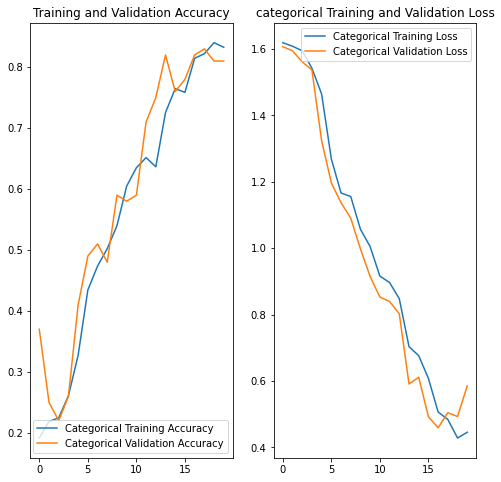

In [88]:
acc = history.history['categorical_accuracy']
val_acc = history.history['val_categorical_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Categorical Training Accuracy')
plt.plot(epochs_range, val_acc, label='Categorical Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Categorical Training Loss')
plt.plot(epochs_range, val_loss, label='Categorical Validation Loss')
plt.legend(loc='upper right')
plt.title('categorical Training and Validation Loss')
plt.show()

## Result
- Training categorical loss = 0.2606
- Training categorical accuracy = 0.9035
- Validation categorical loss = 0.3139
- Validation categorical accuracy: 0.8900

The model is not overfitting as both the training and validation accuracy is similar. Also, the model is having less validation loss from all other models. The number of trainable parameters are 313,605

Best model I got is when using Conv3D + MaxPooling + Dopout + GlobalAveragePooling3D layers
